In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import roc_auc_score

In [3]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import traer_variables_categoricas
from preprocessing import aplicar_one_hot_encoding
from preprocessing import traer_variables_discretas
from preprocessing import traer_variables_numericas

In [4]:
from funcionesAuxiliares import graficar_auc_roc
from funcionesAuxiliares import traer_df

In [5]:
df = traer_df()
df = preparar_dataset(df)
X, y = dividir_dataset(df)

# CategoricalNB

In [6]:
def definir_mejores_hiperparametros_categorical(X, y):    
    metrics = []
    y_array=np.array(y)    
    for alpha in [0.001,0.01,0.5,0.3,0.1,1,2,3,5,10]: 
        kf = StratifiedKFold(n_splits=5)
        metricas_de_la_combinacion = []
        for fold_index, (train_index, test_index) in enumerate(kf.split(X, y_array)):
            print(alpha)
            categoricalNB = CategoricalNB(alpha=alpha)
            categoricalNB.fit(X.iloc[train_index], y.iloc[train_index])
            y_pred = categoricalNB.predict_proba(X.iloc[test_index])[:,1]
            metricas_de_la_combinacion.append(roc_auc_score(y.iloc[test_index], y_pred))
            print(roc_auc_score(y.iloc[test_index], y_pred))

        print(f"Promedio de la combinación: {np.mean(metricas_de_la_combinacion)}")
        metrics.append((alpha,np.mean(metricas_de_la_combinacion)))
                    
    df_metrics = pd.DataFrame(metrics, columns = ['alpha','rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]
    return mejor_combinacion

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      32561 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

In [8]:
X_categoricas = traer_variables_categoricas(X)
X_categoricas = aplicar_one_hot_encoding(X_categoricas)
X_train, X_test, y_train, y_test = train_test_split(X_categoricas, y, test_size=0.25, random_state=0)

In [9]:
mejor_combinacion = definir_mejores_hiperparametros_categorical(X_categoricas, y)
print(mejor_combinacion)

0.001
0.8535366016529813
0.001
0.8522145091349647
0.001
0.8538644295703718
0.001
0.8580667248695595
0.001
0.8554325021877683
Promedio de la combinación: 0.8546229534831291
0.01
0.8535344101224989
0.01
0.8522066403928077
0.01
0.8538636555957334
0.01
0.8581218060646589
0.01
0.855426181394888
Promedio de la combinación: 0.8546305387141174
0.5
0.8534977986720873
0.5
0.8521896129507628
0.5
0.8538159271596988
0.5
0.8581347056419655
0.5
0.8554367590482794
Promedio de la combinación: 0.8546149606945587
0.3
0.8535426605901972
0.3
0.8522007065872466
0.3
0.8538263758173171
0.3
0.8581816601033616
0.3
0.8554312122300376
Promedio de la combinación: 0.8546365230656321
0.1
0.8535378907885591
0.1
0.8522041894731194
0.1
0.8538419843058582
0.1
0.8581683735387359
0.1
0.8554206345766461
Promedio de la combinación: 0.8546346145365838
1
0.8534713713927409
1
0.8521693606143914
1
0.8537770994320057
1
0.8580611780513177
1
0.8554488846509477
Promedio de la combinación: 0.8545855788282808
2
0.8534923843026602
2
0

In [10]:
parametros_categoricalNB = mejor_combinacion.loc[:].values[0]
categoricalNB = CategoricalNB(alpha=parametros_categoricalNB[0])
categoricalNB.fit(X_train, y_train)

CategoricalNB(alpha=0.3)

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.90      0.80      0.84      6159
   Tiene Alto Valor Adquisitivo       0.53      0.71      0.61      1982

                       accuracy                           0.78      8141
                      macro avg       0.71      0.76      0.73      8141
                   weighted avg       0.81      0.78      0.79      8141



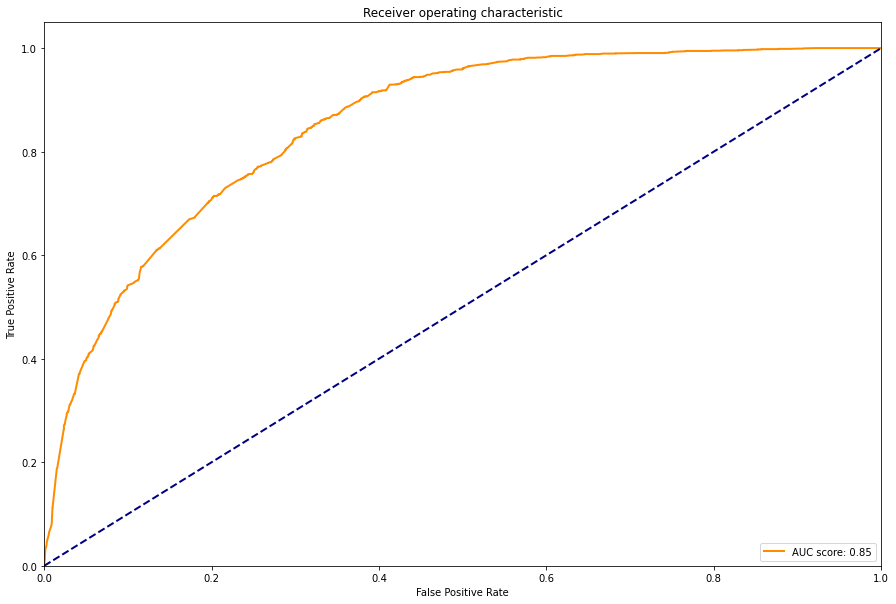

0.8517291686224895

In [11]:
y_pred = categoricalNB.predict(X_test)
y_pred_proba = categoricalNB.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))
graficar_auc_roc(y_test,y_pred_proba)

In [12]:
probabilidades_categorical = categoricalNB.predict_proba(X_train)
probabilidades_x_test_categorical = categoricalNB.predict_proba(X_test)

# MultinomialNB

In [13]:
def definir_mejores_hiperparametros_multinomial(X, y):    
    metrics = []
    y_array=np.array(y)    
    for alpha in [0.001,0.01,0.5,0.3,0.1,1,2,3,5,10]: 
        kf = StratifiedKFold(n_splits=5)
        metricas_de_la_combinacion = []
        for fold_index, (train_index, test_index) in enumerate(kf.split(X, y_array)):
            print(alpha)
            multinomialNB = MultinomialNB(alpha=alpha)
            multinomialNB.fit(X.iloc[train_index], y.iloc[train_index])
            y_pred = multinomialNB.predict_proba(X.iloc[test_index])[:,1]
            metricas_de_la_combinacion.append(roc_auc_score(y.iloc[test_index], y_pred))
            print(roc_auc_score(y.iloc[test_index], y_pred))

        print(f"Promedio de la combinación: {np.mean(metricas_de_la_combinacion)}")
        metrics.append((alpha,np.mean(metricas_de_la_combinacion)))
                    
    df_metrics = pd.DataFrame(metrics, columns = ['alpha','rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]
    return mejor_combinacion

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      32561 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

In [15]:
X_discretas = traer_variables_discretas(X)
X_discretas.info()
X_train, X_test, y_train, y_test = train_test_split(X_discretas, y, test_size=0.25, random_state=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   anios_estudiados           32561 non-null  int64
 1   edad                       32561 non-null  int64
 2   horas_trabajo_registradas  32561 non-null  int64
dtypes: int64(3)
memory usage: 763.3 KB


In [16]:
mejor_combinacion = definir_mejores_hiperparametros_multinomial(X_discretas, y)
print(mejor_combinacion)

0.001
0.5638378004459378
0.001
0.560820475034674
0.001
0.5618287059969619
0.001
0.5534288882421902
0.001
0.5578402856895185
Promedio de la combinación: 0.5595512310818564
0.01
0.5638378004459378
0.01
0.560820475034674
0.01
0.5618287059969619
0.01
0.5534288882421902
0.01
0.5578402856895185
Promedio de la combinación: 0.5595512310818564
0.5
0.5638383161001689
0.5
0.560820475034674
0.5
0.5618285770011888
0.5
0.5534291462337362
0.5
0.5578401566937454
Promedio de la combinación: 0.5595513342127028
0.3
0.5638379293594956
0.3
0.560820475034674
0.3
0.5618285770011888
0.3
0.5534291462337362
0.3
0.5578401566937454
Promedio de la combinación: 0.5595512568645681
0.1
0.5638379293594956
0.1
0.560820475034674
0.1
0.5618287059969619
0.1
0.5534291462337362
0.1
0.5578402856895185
Promedio de la combinación: 0.5595513084628772
1
0.5638384450137267
1
0.560820346038901
1
0.5618227721914009
1
0.553432629119609
1
0.5578401566937455
Promedio de la combinación: 0.5595508698114766
2
0.5638381871866112
2
0.56082

In [17]:
parametros_multinomialNB = mejor_combinacion.loc[:].values[0]
multinomialNB = MultinomialNB(alpha=parametros_multinomialNB[0])
multinomialNB.fit(X_train, y_train)

MultinomialNB(alpha=3.0)

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.76      1.00      0.86      6159
   Tiene Alto Valor Adquisitivo       0.00      0.00      0.00      1982

                       accuracy                           0.76      8141
                      macro avg       0.38      0.50      0.43      8141
                   weighted avg       0.57      0.76      0.65      8141



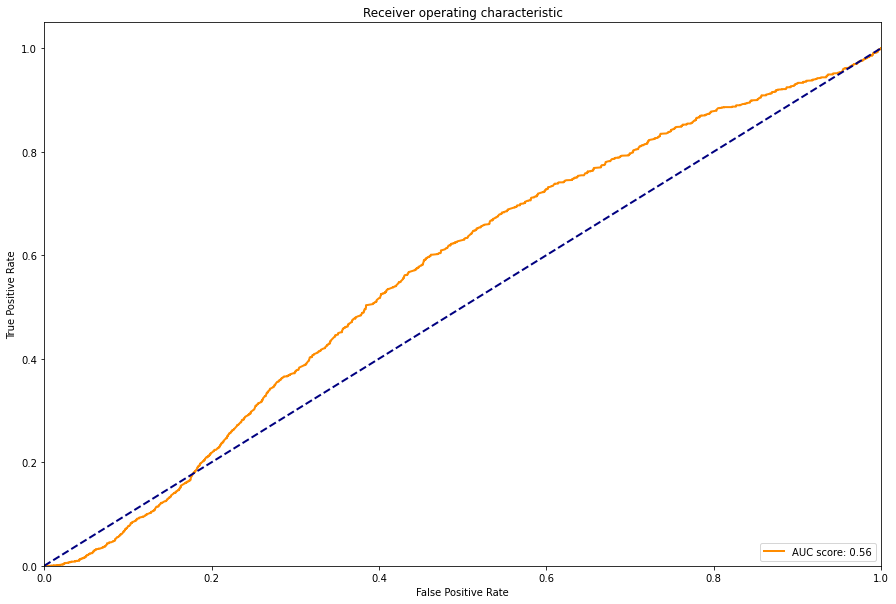

0.5634842499527736

In [18]:
y_pred = multinomialNB.predict(X_test)
y_pred_proba = multinomialNB.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))
graficar_auc_roc(y_test,y_pred_proba)

# GaussianNB

In [19]:
def definir_mejores_hiperparametros_gaussian(X, y):    
    metrics = []
    y_array=np.array(y)    
    for smoothing in [0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001]:
        kf = StratifiedKFold(n_splits=5)
        metricas_de_la_combinacion = []
        for fold_index, (train_index, test_index) in enumerate(kf.split(X, y_array)):
            print(smoothing)
            gaussianNB = GaussianNB(var_smoothing = smoothing)
            gaussianNB.fit(X.iloc[train_index], y.iloc[train_index])
            y_pred = gaussianNB.predict_proba(X.iloc[test_index])[:,1]
            metricas_de_la_combinacion.append(roc_auc_score(y.iloc[test_index], y_pred))
            print(roc_auc_score(y.iloc[test_index], y_pred))

        print(f"Promedio de la combinación: {np.mean(metricas_de_la_combinacion)}")
        metrics.append((smoothing,np.mean(metricas_de_la_combinacion)))
                    
    df_metrics = pd.DataFrame(metrics, columns = ['smoothing','rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]
    return mejor_combinacion

In [20]:
X_discretas = traer_variables_discretas(X)
X_train, X_test, y_train, y_test = train_test_split(X_discretas, y, test_size=0.25, random_state=0)

In [21]:
mejor_combinacion = definir_mejores_hiperparametros_gaussian(X_discretas, y)
print(mejor_combinacion)

1e-09
0.8084217551426196
1e-09
0.8040853477313255
1e-09
0.8120874715177332
1e-09
0.820952706021729
1e-09
0.8184181970725184
Promedio de la combinación: 0.8127930954971851
1e-08
0.8084217551426196
1e-08
0.8040852187355524
1e-08
0.8120874715177332
1e-08
0.820952835017502
1e-08
0.8184181970725184
Promedio de la combinación: 0.8127930954971851
1e-07
0.8084216262290618
1e-07
0.8040853477313255
1e-07
0.8120874715177333
1e-07
0.8209530930090483
1e-07
0.8184185840598377
Promedio de la combinación: 0.8127932245094012
1e-06
0.8084214973155041
1e-06
0.8040858637144178
1e-06
0.8120879875008254
1e-06
0.8209490941400832
1e-06
0.8184187130556105
Promedio de la combinación: 0.8127926311452882
1e-05
0.8084389006458053
1e-05
0.8040791559342183
1e-05
0.8120878585050526
1e-05
0.8209496101231755
1e-05
0.818423227907668
Promedio de la combinación: 0.8127957506231839
0.0001
0.8084878877977646
0.0001
0.8040897335876097
0.0001
0.8121172695413117
0.0001
0.8209668955567663
0.0001
0.8184552188593885
Promedio de l

In [22]:
parametros_gaussianNB = mejor_combinacion.loc[:].values[0]
gaussianNB = GaussianNB(var_smoothing=parametros_gaussianNB[0])
gaussianNB.fit(X_train, y_train)

GaussianNB(var_smoothing=0.001)

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.82      0.94      0.87      6159
   Tiene Alto Valor Adquisitivo       0.65      0.36      0.46      1982

                       accuracy                           0.80      8141
                      macro avg       0.73      0.65      0.67      8141
                   weighted avg       0.78      0.80      0.77      8141



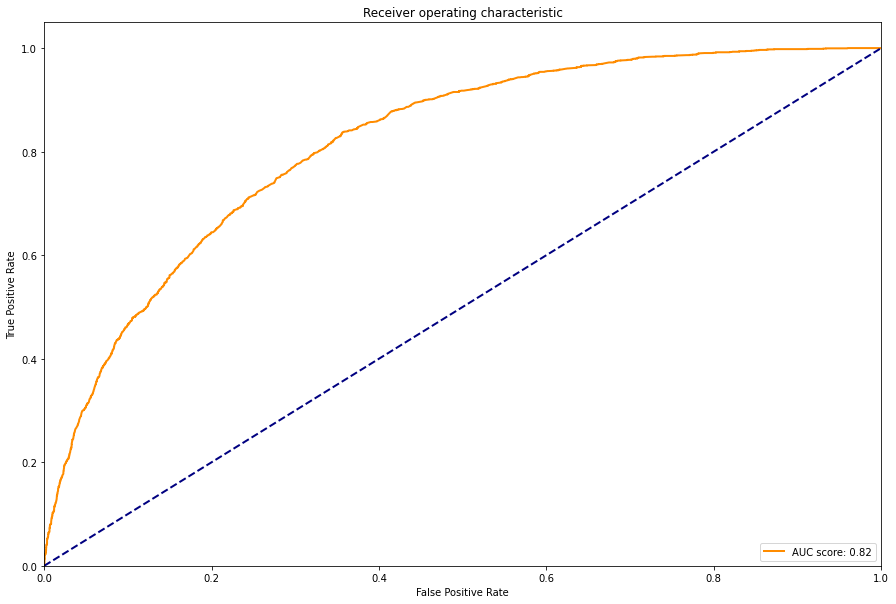

0.815661295874594

In [23]:
y_pred = gaussianNB.predict(X_test)
y_pred_proba = gaussianNB.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))
graficar_auc_roc(y_test,y_pred_proba)

In [24]:
X_numericas = traer_variables_numericas(X)
X_train, X_test, y_train, y_test = train_test_split(X_numericas, y, test_size=0.25, random_state=0)

In [25]:
mejor_combinacion = definir_mejores_hiperparametros_gaussian(X_numericas, y)
print(mejor_combinacion)

1e-09
0.8287347288999445
1e-09
0.8289684388621954
1e-09
0.8415662950556435
1e-09
0.8354817579337561
1e-09
0.8432071212890496
Promedio de la combinación: 0.8355916684081178
1e-08
0.8292238269381895
1e-08
0.8291943104608349
1e-08
0.8416595589995708
1e-08
0.8351649443151048
1e-08
0.8432966443555578
Promedio de la combinación: 0.8357078570138515
1e-07
0.8274043409835795
1e-07
0.8261244690533982
1e-07
0.8378028433764282
1e-07
0.8302748435539264
1e-07
0.8401674648925104
Promedio de la combinación: 0.8323547923719685
1e-06
0.8053313748785633
1e-06
0.8002542377691368
1e-06
0.8121375863755698
1e-06
0.8024943138663232
1e-06
0.8157410832961827
Promedio de la combinación: 0.807191719237155
1e-05
0.7825603418581291
1e-05
0.7747404218058582
1e-05
0.7866881393030513
1e-05
0.7775578829832905
1e-05
0.7949545754284724
Promedio de la combinación: 0.7833002722757604
0.0001
0.7745689904108939
0.0001
0.767682160090978
0.0001
0.7787040749248729
0.0001
0.7691245263275213
0.0001
0.7889068665997951
Promedio de 

In [26]:
parametros_gaussianNB = mejor_combinacion.loc[:].values[0]
gaussianNB = GaussianNB(var_smoothing=parametros_gaussianNB[0])
gaussianNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-08)

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.80      0.98      0.88      6159
   Tiene Alto Valor Adquisitivo       0.76      0.23      0.35      1982

                       accuracy                           0.80      8141
                      macro avg       0.78      0.60      0.62      8141
                   weighted avg       0.79      0.80      0.75      8141



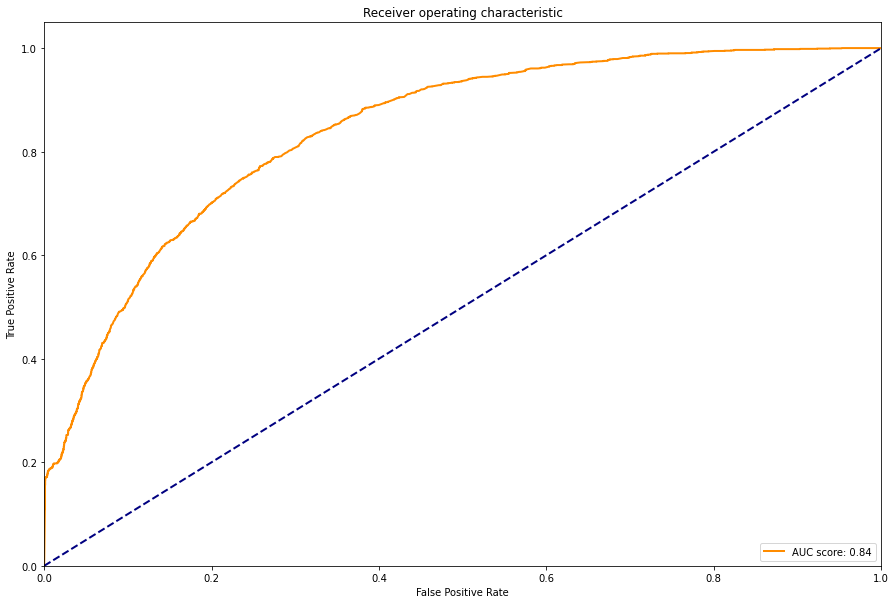

0.840012826921429

In [27]:
y_pred = gaussianNB.predict(X_test)
y_pred_proba = gaussianNB.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))
graficar_auc_roc(y_test,y_pred_proba)

In [28]:
probabilidades_gaussian = gaussianNB.predict_proba(X_train)
probabilidades_x_test_gaussian = gaussianNB.predict_proba(X_test)

# Ensamble Gaussiano

In [34]:
def definir_mejores_hiperparametros_ensamble(arrayProbabilidades, y):    
    metrics = []
    y_array=np.array(y)    
    for smoothing in [0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001]:
        kf = StratifiedKFold(n_splits=5)
        metricas_de_la_combinacion = []
        for fold_index, (train_index, test_index) in enumerate(kf.split(X, y_array)):
            print(smoothing)
            gaussianNB = GaussianNB(var_smoothing = smoothing)
            gaussianNB.fit(arrayProbabilidades[train_index], y.iloc[train_index])
            y_pred = gaussianNB.predict_proba(arrayProbabilidades[test_index])[:,1]
            metricas_de_la_combinacion.append(roc_auc_score(y.iloc[test_index], y_pred))
            print(roc_auc_score(y.iloc[test_index], y_pred))

        print(f"Promedio de la combinación: {np.mean(metricas_de_la_combinacion)}")
        metrics.append((smoothing,np.mean(metricas_de_la_combinacion)))
                    
    df_metrics = pd.DataFrame(metrics, columns = ['smoothing','rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]
    return mejor_combinacion

In [35]:
probabilidades_x_train = np.hstack(( probabilidades_categorical , probabilidades_gaussian))
probabilidades_x_test = np.hstack(( probabilidades_x_test_categorical , probabilidades_x_test_gaussian))

In [36]:
X_ensamble_gaussiano = np.vstack((probabilidades_x_train,probabilidades_x_test))
mejor_combinacion = definir_mejores_hiperparametros_ensamble(X_ensamble_gaussiano, y)
print(mejor_combinacion)

1e-09
[[4.96310433e-02 9.50368957e-01 8.93133712e-01 1.06866288e-01]
 [9.99341213e-01 6.58787232e-04 9.03853493e-01 9.61465073e-02]
 [2.71802823e-02 9.72819718e-01 9.78526090e-01 2.14739102e-02]
 ...
 [8.49722958e-01 1.50277042e-01 9.85576051e-01 1.44239495e-02]
 [1.09316779e-02 9.89068322e-01 9.05027922e-01 9.49720779e-02]
 [9.99295640e-01 7.04359844e-04 9.73701489e-01 2.62985108e-02]]
0.5058202537637603
1e-09
[[9.99547798e-01 4.52202320e-04 9.87993171e-01 1.20068290e-02]
 [9.97586226e-01 2.41377433e-03 9.85879079e-01 1.41209207e-02]
 [1.33811699e-02 9.86618830e-01 9.27995898e-01 7.20041015e-02]
 ...
 [8.49722958e-01 1.50277042e-01 9.85576051e-01 1.44239495e-02]
 [1.09316779e-02 9.89068322e-01 9.05027922e-01 9.49720779e-02]
 [9.99295640e-01 7.04359844e-04 9.73701489e-01 2.62985108e-02]]
0.5081048689196552
1e-09
[[9.99547798e-01 4.52202320e-04 9.87993171e-01 1.20068290e-02]
 [9.97586226e-01 2.41377433e-03 9.85879079e-01 1.41209207e-02]
 [1.33811699e-02 9.86618830e-01 9.27995898e-01 7.2

In [32]:
parametros_gaussianNB = mejor_combinacion.loc[:].values[0]
ensambleGaussiano = GaussianNB(var_smoothing=parametros_gaussianNB[0])
ensambleGaussiano.fit(probabilidades_x_train, y_train)

GaussianNB(var_smoothing=0.001)

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.88      0.89      0.89      6159
   Tiene Alto Valor Adquisitivo       0.65      0.63      0.64      1982

                       accuracy                           0.83      8141
                      macro avg       0.77      0.76      0.76      8141
                   weighted avg       0.83      0.83      0.83      8141



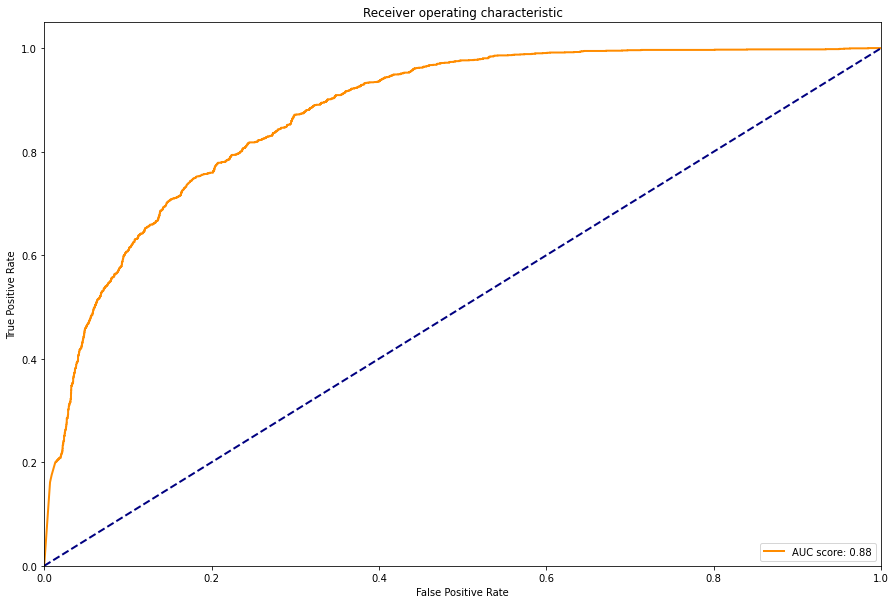

0.8753559597671461

In [33]:
y_pred = ensambleGaussiano.predict(probabilidades_x_test)
y_pred_proba = ensambleGaussiano.predict_proba(probabilidades_x_test)[:,1]
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))
graficar_auc_roc(y_test,y_pred_proba)